### DENSE NET MODEL

In [ ]:
!pip install tensorflow
!pip install keras_preprocessing
!pip install keras
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras_preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, AveragePooling2D
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TRAIN_DIR = 'drive/MyDrive/images/train'
TEST_DIR = 'drive/MyDrive/images/test'

In [ ]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir,label)):
            image_paths.append(os.path.join(dir,label,imagename))
            labels.append(label)
        print(label, "completed")
    return image_paths,labels


In [ ]:
import random

# Function to create DataFrame containing limited number of image paths and labels
def create_limited_dataframe(dir, max_images_per_label):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        label_images = [os.path.join(dir, label, imagename) for imagename in os.listdir(os.path.join(dir, label))]
        random.shuffle(label_images)  # Shuffle the images for randomness
        label_images = label_images[:max_images_per_label]  # Select a limited number of images per label
        image_paths.extend(label_images)
        labels.extend([label] * len(label_images))
        print(f"{label}: {len(label_images)} images completed")
    return image_paths, labels

# Define the maximum number of images per label
MAX_IMAGES_PER_LABEL = 1000

# Create limited DataFrames for train and test data
train = pd.DataFrame()
train['image'], train['label'] = create_limited_dataframe(TRAIN_DIR, MAX_IMAGES_PER_LABEL)

test = pd.DataFrame()
test['image'], test['label'] = create_limited_dataframe(TEST_DIR, MAX_IMAGES_PER_LABEL)

neutral: 1000 images completed
sad: 1000 images completed
happy: 1000 images completed
surprise: 1000 images completed
angry: 1000 images completed
angry: 960 images completed
happy: 1000 images completed
surprise: 797 images completed
neutral: 1000 images completed
sad: 1000 images completed


In [ ]:
import pickle


In [ ]:
pickle.dump(train,open('/content/drive/MyDrive/comparison_model_trained/train_data_dense', 'wb'))

In [ ]:
def extract_features(images):
    features = []
    for image in images:
        img = load_img(image,grayscale =  True )
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),48,48,1)
    return features


In [ ]:
from keras.layers import Input
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization, Activation, Conv2D, concatenate, MaxPooling2D

# Extract features for train and test data
train_features = extract_features(train['image'])
test_features = extract_features(test['image'])

# Normalize features
x_train = train_features / 255.0
x_test = test_features / 255.0

# Encode labels
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

# Define DenseNet model architecture
def dense_block(x, blocks, growth_rate):
    for i in range(blocks):
        x = conv_block(x, growth_rate)
    return x

def conv_block(x, growth_rate):
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(growth_rate, (3, 3), padding='same', use_bias=False)(x1)
    x = concatenate([x, x1], axis=-1)
    return x

def transition_layer(x, compression_factor):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(x.shape[-1] * compression_factor), (1, 1), padding='same', use_bias=False)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    return x

input_shape = (48, 48, 1)
img_input = Input(shape=input_shape)

x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(img_input)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = dense_block(x, 6, 32)
x = transition_layer(x, 0.5)
x = dense_block(x, 12, 32)
x = transition_layer(x, 0.5)
x = dense_block(x, 24, 32)
x = transition_layer(x, 0.5)
x = dense_block(x, 16, 32)

x = GlobalAveragePooling2D()(x)
x = Dense(7, activation='softmax')(x)




/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
from keras.models import Model
import pickle

model = Model(img_input, x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x=x_train, y=y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test))


pickle.dump(model,open('/content/drive/MyDrive/comparison_model_model/trained_model_dense', 'wb'))

Epoch 1/50
40/40 [==============================] - 246s 6s/step - loss: 1.7836 - accuracy: 0.2916 - val_loss: 1.6107 - val_accuracy: 0.2100
Epoch 2/50
40/40 [==============================] - 226s 6s/step - loss: 1.4921 - accuracy: 0.3762 - val_loss: 1.6146 - val_accuracy: 0.2102
Epoch 3/50
40/40 [==============================] - 229s 6s/step - loss: 1.3633 - accuracy: 0.4296 - val_loss: 1.6196 - val_accuracy: 0.2102
Epoch 4/50
40/40 [==============================] - 227s 6s/step - loss: 1.2604 - accuracy: 0.4870 - val_loss: 1.6687 - val_accuracy: 0.2104
Epoch 5/50
40/40 [==============================] - 228s 6s/step - loss: 1.1036 - accuracy: 0.5616 - val_loss: 1.5486 - val_accuracy: 0.3038
Epoch 6/50
40/40 [==============================] - 226s 6s/step - loss: 0.9747 - accuracy: 0.6142 - val_loss: 1.6171 - val_accuracy: 0.2899
Epoch 7/50
40/40 [==============================] - 226s 6s/step - loss: 0.9577 - accuracy: 0.6200 - val_loss: 1.4208 - val_accuracy: 0.3662
Epoch 8/50
40

KeyboardInterrupt: 

original image is of sad
1/1 [==============================] - 0s 93ms/step
model prediction is  neutral


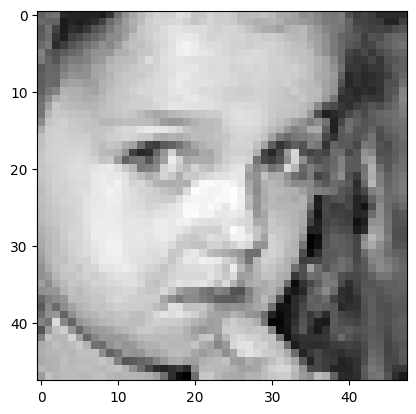

In [ ]:
# Define labels
label = ['angry', 'happy', 'neutral', 'sad', 'surprise']

# Function to extract features from image
def ef(image):
    img = load_img(image, grayscale=True, target_size=(48, 48))  # Resizing images to a consistent size
    feature = np.array(img)
    feature = feature.reshape(1, 48, 48, 1)
    return feature / 255.0

# Prediction and visualization
image = 'drive/MyDrive/images/test/sad/22977.jpg'
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ", pred_label)

# Display the image
plt.imshow(img.reshape(48, 48), cmap='gray')

original image is of happy
1/1 [==============================] - 0s 157ms/step
model prediction is  happy


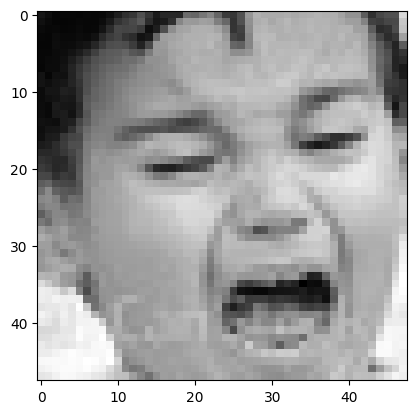

In [ ]:
image = 'drive/MyDrive/images/train/angry/24638.jpg'
print("original image is of angry")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of surprise
1/1 [==============================] - 0s 39ms/step
model prediction is  surprise


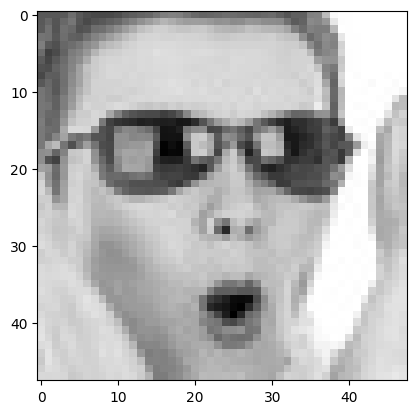

In [ ]:
image = 'drive/MyDrive/images/test/surprise/21299.jpg'
print("original image is of surprise")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of surprise
1/1 [==============================] - 0s 40ms/step
model prediction is  neutral


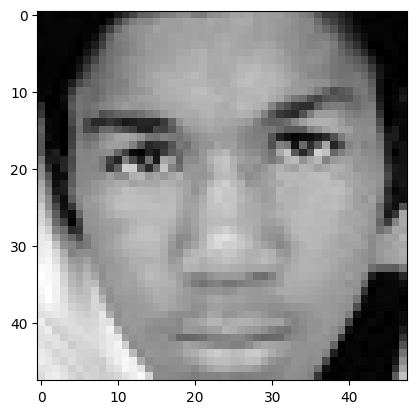

In [ ]:
image = 'drive/MyDrive/images/test/neutral/24912.jpg'
print("original image is of neutral")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')